<a href="https://colab.research.google.com/github/Diya-Amith/ADS-1/blob/main/GalaxyMorphologyClassification_DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Data Loading**

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


drive.mount('/content/drive')

# Define paths for dataset
data_dir = '/content/drive/MyDrive/galaxy-zoo-the-galaxy-challenge'
train_images_dir = os.path.join(data_dir, 'images_training_rev1', 'images_training_rev1')
labels_file = os.path.join(data_dir, 'training_solutions_rev1', 'training_solutions_rev1.csv')


Mounted at /content/drive


# **Load and Clean Labels**

In [ ]:
# Load labels
try:
    labels_df = pd.read_csv(labels_file)
    labels_df.set_index('GalaxyID', inplace=True)  # Set GalaxyID as the index
    print("Labels loaded successfully.")
except FileNotFoundError:
    print("Error: Labels file not found. Check the path and filename.")

# Verify a sample of Galaxy IDs to match images
print("Sample GalaxyIDs from labels file:", labels_df.index[:10])

# Initialize lists to store images and labels
files = os.listdir(train_images_dir)
print(f"Total images in directory: {len(files)}")
print(f"Missing images: {[str(img_id) + '.jpg' for img_id in labels_df.index if f'{img_id}.jpg' not in files]}")

# Assuming the labels in labels_df do not have '.jpg' extension
missing_images = [str(img_id) for img_id in labels_df.index if f'{img_id}.jpg' not in files]

# Remove corresponding labels from the dataframe
labels_df_cleaned = labels_df.drop(labels=missing_images, errors='ignore')

# Verify the result
print(f"Cleaned labels dataframe shape: {labels_df_cleaned.shape}")
print(labels_df_cleaned.head())


Labels loaded successfully.
Sample GalaxyIDs from labels file: Index([100008, 100023, 100053, 100078, 100090, 100122, 100123, 100128, 100134,
       100143],
      dtype='int64', name='GalaxyID')
Total images in directory: 17499
Missing images: ['358064.jpg', '358083.jpg', '358091.jpg', '358093.jpg', '358101.jpg', '358103.jpg', '358109.jpg', '358125.jpg', '358143.jpg', '358161.jpg', '358167.jpg', '358171.jpg', '358186.jpg', '358219.jpg', '358237.jpg', '358239.jpg', '358269.jpg', '358273.jpg', '358277.jpg', '358291.jpg', '358304.jpg', '358316.jpg', '358338.jpg', '358341.jpg', '358343.jpg', '358345.jpg', '358347.jpg', '358363.jpg', '358365.jpg', '358393.jpg', '358426.jpg', '358445.jpg', '358458.jpg', '358460.jpg', '358465.jpg', '358468.jpg', '358487.jpg', '358505.jpg', '358511.jpg', '358521.jpg', '358534.jpg', '358538.jpg', '358583.jpg', '358590.jpg', '358622.jpg', '358623.jpg', '358651.jpg', '358660.jpg', '358664.jpg', '358679.jpg', '358735.jpg', '358764.jpg', '358827.jpg', '358857.jpg'

# **Define Image Preprocessing Function**

In [ ]:
import tensorflow as tf

# Define the image loading and preprocessing function
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image as RGB
    img = tf.image.resize(img, target_size)  # Resize the image
    img = img / 255.0  # Normalize the image
    return img


# **Create TensorFlow Dataset**

In [ ]:
# Create a list of image paths from the labels dataframe
image_paths = [os.path.join(train_images_dir, f"{img_id}.jpg") for img_id in labels_df_cleaned.index]

# Create a TensorFlow dataset from the list of image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the load and preprocess function onto the dataset
dataset = dataset.map(lambda x: load_and_preprocess_image(x, target_size=(128, 128)), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the dataset for efficient training
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Verify that the dataset is ready
for images in dataset.take(1):
    print(f"Batch shape: {images.shape}")


Batch shape: (32, 128, 128, 3)


# **Install Keras and Define Image Loading Function**

In [ ]:
!pip install keras

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess images
def load_and_process_image(galaxy_id):
    img_filename = f"{int(galaxy_id)}.jpg"
    img_path = os.path.join(train_images_dir, img_filename)
    if os.path.isfile(img_path):
        img = Image.open(img_path).resize((128, 128), Image.LANCZOS).convert('RGB')
        img_array = np.array(img) / 255.0  # Normalize image
        return img_array
    else:
        return None


# **Load Image Data with Multiprocessing**

In [ ]:
# Set a limit for the number of images to load, e.g., 5000 images
subset_size = 5000
sampled_galaxy_ids = np.random.choice(labels_df_cleaned.index, subset_size, replace=False)

# Parallelize the image loading process using multiprocessing
from multiprocessing import Pool

with Pool() as pool:
    images = pool.map(load_and_process_image, sampled_galaxy_ids)

# Remove any None entries (if any image couldn't be loaded)
images = [img for img in images if img is not None]

# Convert images to a NumPy array
images = np.array(images)

print(f"Loaded {len(images)} images.")


Loaded 1394 images.


# **Extract Labels and Augment Data**

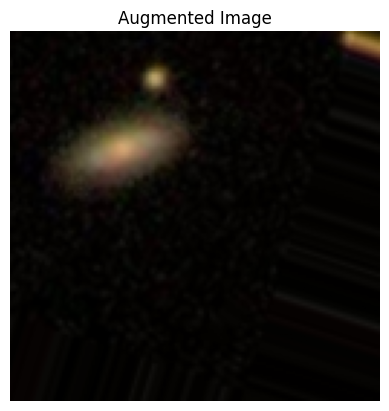

In [ ]:
# Extract the corresponding labels for the sampled Galaxy IDs
labels_subset = labels_df_cleaned.loc[sampled_galaxy_ids].values  # This gives the labels as an array

# Data Augmentation Example
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate image by up to 30 degrees
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill empty pixels after transformation
)

# Apply augmentation to the image data (example for the first image in the dataset)
datagen.fit(images)  # Fit the generator to your images

# Optionally, augment a single image to see the effect
augmented_image = datagen.random_transform(images[0])
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')
plt.show()


# **Extract Local Binary Pattern (LBP) Features**

In [ ]:
from skimage.feature import local_binary_pattern

# Function to extract Local Binary Pattern (LBP) features from an image
def extract_lbp_features(image):
    # Parameters for LBP
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')

    # Compute the histogram of LBP values
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Normalize the histogram
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= lbp_hist.sum()

    return lbp_hist

# Extract LBP features from all images
lbp_features = [extract_lbp_features(np.mean(img, axis=-1)) for img in images]  # Convert images to grayscale

# Convert features to a NumPy array
lbp_features = np.array(lbp_features)

print(f"Extracted LBP features from {len(lbp_features)} images.")


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features from 1394 images.


# **Combine Features with Labels**

In [ ]:
# Check initial lengths of images and labels
print(f"Initial number of images: {len(images)}")
print(f"Initial number of labels: {len(labels_subset)}")

# Step 1: Filter out None images before feature extraction
valid_images = []
valid_labels = []

for i, img in enumerate(images):
    if img is not None:
        valid_images.append(img)
        valid_labels.append(labels_subset[i])  # Ensure label alignment

# Convert to NumPy array
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Confirm shapes after filtering
print(f"Filtered number of images: {len(valid_images)}")
print(f"Filtered number of labels: {len(valid_labels)}")

# Step 2: Extract LBP features from valid images
lbp_features = [extract_lbp_features(np.mean(img, axis=-1)) for img in valid_images]
lbp_features = np.array(lbp_features)

# Confirm shapes of features and labels
print(f"LBP features shape: {lbp_features.shape}")
print(f"Labels shape: {valid_labels.shape}")

# Step 3: Combine features and labels if they match
if lbp_features.shape[0] == valid_labels.shape[0]:
    final_dataset = np.hstack((lbp_features, valid_labels))
    print(f"Final dataset shape: {final_dataset.shape}")
else:
    print("Error: The number of LBP features does not match the number of labels.")
    print(f"Number of LBP features: {lbp_features.shape[0]}")
    print(f"Number of labels: {valid_labels.shape[0]}")


Initial number of images: 1394
Initial number of labels: 5000
Filtered number of images: 1394
Filtered number of labels: 1394
LBP features shape: (1394, 10)
Labels shape: (1394, 37)
Final dataset shape: (1394, 47)


# **EDA**

## **Summary statistics**

In [18]:
import pandas as pd

# Assuming 'final_dataset' contains LBP features and labels combined
# Convert it to a DataFrame for better manipulation
final_df = pd.DataFrame(final_dataset)

# Get summary statistics for the dataset
summary_stats = final_df.describe()
print(summary_stats)


                0            1            2            3            4   \
count  1394.000000  1394.000000  1394.000000  1394.000000  1394.000000   
mean      0.066669     0.082719     0.073053     0.119113     0.124002   
std       0.025628     0.015736     0.008474     0.030337     0.050025   
min       0.003357     0.015808     0.011780     0.061157     0.056702   
25%       0.045914     0.072540     0.068436     0.091019     0.083313   
50%       0.066956     0.086700     0.074463     0.119720     0.110718   
75%       0.088654     0.095703     0.078918     0.144821     0.150131   
max       0.118530     0.107361     0.091675     0.179016     0.317505   

                5            6            7            8            9   ...  \
count  1394.000000  1394.000000  1394.000000  1394.000000  1394.000000  ...   
mean      0.094238     0.072980     0.084221     0.134983     0.148022  ...   
std       0.029866     0.006873     0.016266     0.031143     0.041080  ...   
min       0.05456

## **Checking for missing data**

In [19]:
# Check for missing values in the dataset
missing_data = final_df.isnull().sum()
print("Missing values:\n", missing_data)


Missing values:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
dtype: int64


## **Visualizing LBP Features Distribution**

<Figure size 1500x1000 with 0 Axes>

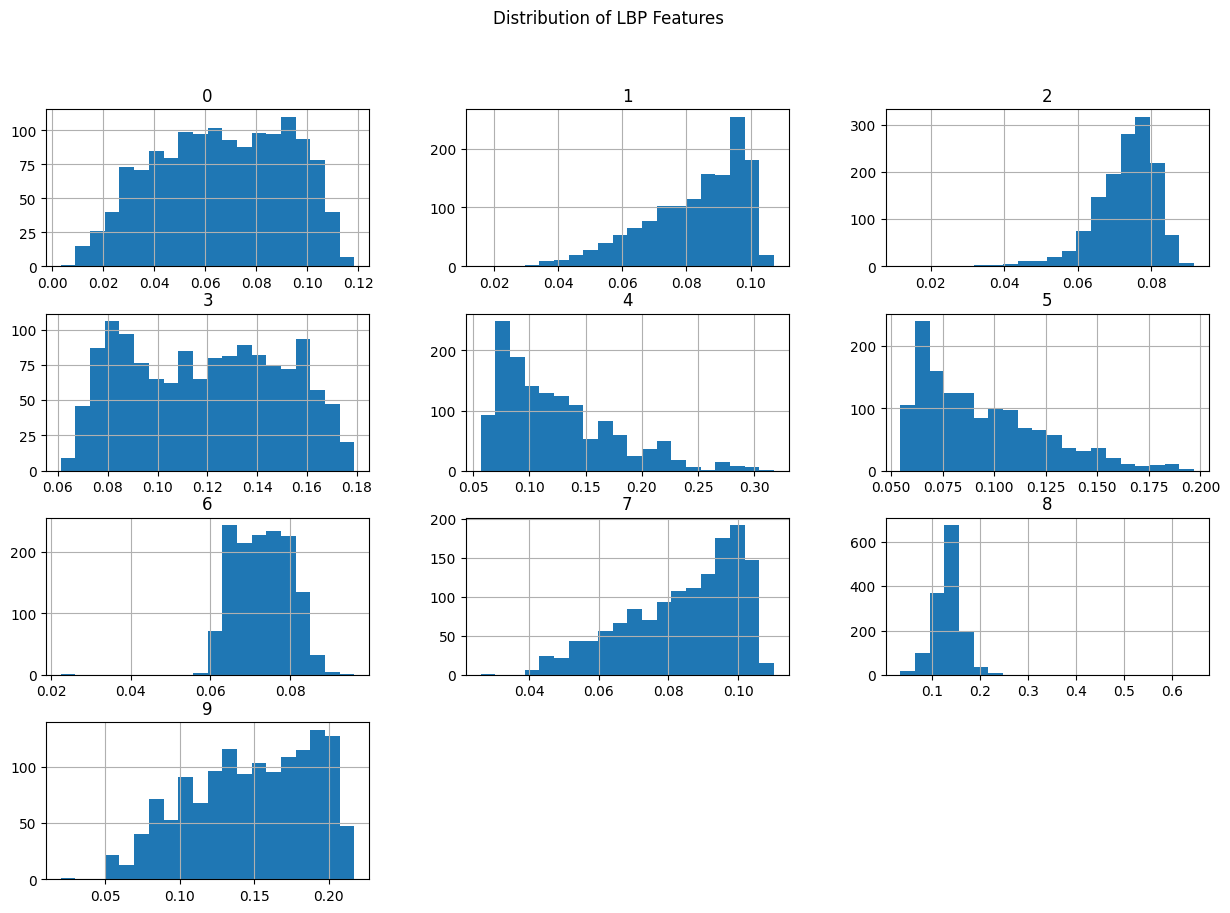

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each LBP feature
plt.figure(figsize=(15, 10))
final_df.iloc[:, :-37].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of LBP Features")
plt.show()


## **Visualizing Label Distribution**

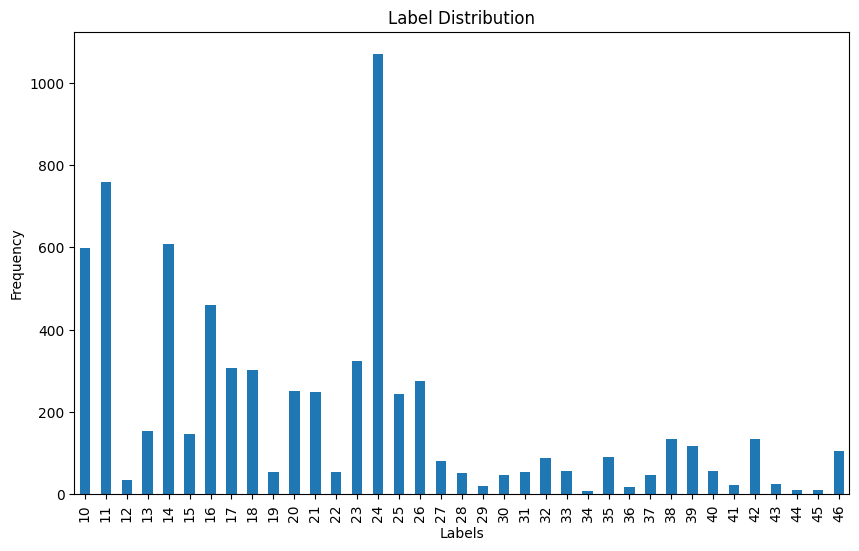

In [21]:
# Check label distribution (assuming labels are in the last 37 columns)
label_counts = final_df.iloc[:, -37:].sum(axis=0)

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()


## ** Data Splitting**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Split the dataset into training and testing sets (80-20 split)
X = final_dataset[:, :-37]  # Features (LBP features)
y = final_dataset[:, -37:]  # Labels

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Further split the training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print shapes to confirm the splits and scaling
print(f"Training set shape: X_train = {X_train_scaled.shape}, y_train = {y_train.shape}")
print(f"Validation set shape: X_val = {X_val_scaled.shape}, y_val = {y_val.shape}")
print(f"Test set shape: X_test = {X_test_scaled.shape}, y_test = {y_test.shape}")


Training set shape: X_train = (892, 10), y_train = (892, 37)
Validation set shape: X_val = (223, 10), y_val = (223, 37)
Test set shape: X_test = (279, 10), y_test = (279, 37)


In [48]:
# Reset the index to move the 'level_0' column back to a regular column
df_galaxies = df_galaxies.reset_index()

# Rename 'level_0' to 'GalaxyID' if needed
df_galaxies.rename(columns={'level_0': 'GalaxyID'}, inplace=True)

# Verify the changes
print(df_galaxies.columns)  # Ensure 'GalaxyID' is now a column


Index(['GalaxyID', 'index', 'GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3',
       'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2',
       'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2',
       'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3',
       'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2',
       'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1',
       'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6',
       'class'],
      dtype='object')


## **VGG16 Model Implementation**